In [30]:
import numpy as np
import numpy.linalg as LA
from numpy.linalg import norm, solve, multi_dot
import matplotlib.pyplot as plt
#from scipy.optimize import minimize_scalar


"""
@def   : objective function 
@param : x is vector 
@return: a scalar
"""
def objective_func(x):
    return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

"""
@def   : gradient of objective function 
@param : x is vector 
@return: a vector 
"""
def grad_objective_func(x):
    return np.array([
        -400 * x[0] * (x[1] - x[0] ** 2) - 2 * (1 - x[0]),
        200 * (x[1] - x[0]**2)      
    ])


def hessian_func(x):
    return np.matrix([
        [-400*(x[1] - 3*x[0]**2) + 2, -400 * x[0]], [-400 * x[0], 200]
    ])


# The stopping criteria is the gradient is less than 1e-9.

In [31]:
hessian_func([1.2, -1])

matrix([[2130., -480.],
        [-480.,  200.]])

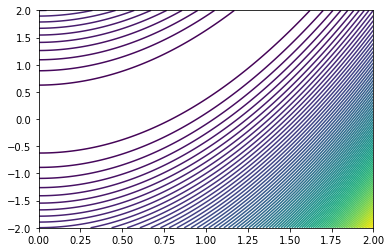

In [32]:
# In[2]:


# contour plot of objective function
# additional code: contour plots for objective function

# set the region to plot on
x = np.linspace(-0, 2, 500)
y = np.linspace(-2, 2, 500)
X, Y = np.meshgrid(x, y)

# evaluate function
Z = objective_func([X,Y])

# contour plots of objective function, with 15 contour lines.
plt.contour(X, Y, Z, 90);
# plt.contour(X, Y, Z, 15, colors='black'); # only black color

In [33]:
# In[3]:


"""
@def   : evaluation of model function
@param : p vector, g gradient vector, B model's matrix for quadratic term.
@return: a number
"""
def model(x, p):
    return objective_func(x) + np.dot(p, grad_objective_func(x)) + 0.5 * multi_dot([p.T, hessian_func(x), p])

"""
@def   : evaluate the actual reduction.
@param : x vector, p vector, g gradient vector, B model's matrix for quadratic term.
@return: a number
"""
def rho(x, p):
    return (objective_func(x) - objective_func(x + p)) / (model(x, np.array([0, 0]))  - model(x, p))

# framework for trust region method, we use the Hessian as the model's Bk.
"""
@def   : trust region method.
@param : subproblem_solver is a function, x0 starting point, radius0 the starting radius (also the max radius).
@return: a point
"""
def trust_region(subproblem_solver, x0, radius0):
    # The algorithm is modified from Algorithm 4.1 in the book.
    xcoords = [x0[0]]
    ycoords = [x0[1]]
    iter    = 0
    x = x0 
    radius = radius0
    err = norm(grad_objective_func(x))
    while (err > 1e-9):
        # main iterations for trust region.
        p = subproblem_solver(x, radius)
        # then test whether we should accept this point, calculate the ratio
        r = rho(x, p)
        if r < 0.25:
            # reject this because it is too small, x is not updated, only radius is updated
            radius = 0.5 * radius 
        elif r > 0.75:
            # accept this 
            radius = min(2 * radius , radius0) # cannot exceed maximum region size
            x = x + p
        else:
            # we also accept this, but region size is not changed
            x = x + p
            
        xcoords.append(x[0])
        ycoords.append(x[1])
        iter = iter + 1
            
        # update err
        err = norm(grad_objective_func(x))
            
    return x, iter, xcoords, ycoords

In [45]:
"""
@def   : evaluate Dogleg's step
@param : 
@return: 
"""
def dogleg(x, radius):
    print(x)
    grad = grad_objective_func(x)
    hess = hessian_func(x)
    pn = -solve(hess,grad)
    if norm(pn) <= radius:
        return pn
    else:
        ps = -(norm(grad)**2)/(multi_dot([grad.T, hess, grad]))*grad
        if norm(ps) <= radius:
            a = norm(ps - pn)**2
            b = 2* np.dot(ps,(ps - pn))
            c = norm(ps)**2-radius**2
            inner = (b)**2 - 4*(a)*(c) #b**2 - 4*a*c
            if inner < 0:
                return print('No Real Root')
            t = (-b + np.sqrt(inner))/(2*a)
            return (1-t)*ps + t*pn
        return -radius*grad/norm(grad)

In [35]:
# In[4]:


"""
@def: Cauchy point method for the subproblem.
"""
def cauchy_point(x, radius):
    grad = grad_objective_func(x)
    hess = hessian_func(x)
    if multi_dot([grad.T, hess, grad]) <= 0:
        return -radius / norm(grad) * grad 
    else:
        k = norm(grad)**3 / (radius * multi_dot([grad.T, hess, grad]))
        return min(1, k) * (-radius / norm(grad) * grad)

In [36]:
# In[5]:


x0 = np.array([1.2, -1])
x, iter, xcoords, ycoords  = trust_region(cauchy_point, x0, 2)
print(x, iter)

[1. 1.] 20304


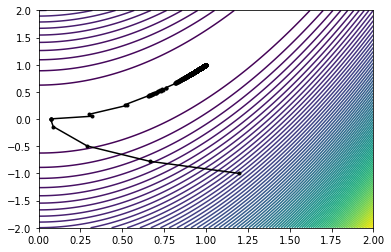

In [37]:
# In[6]:


plt.contour(X, Y, Z, 90);
plt.plot(xcoords, ycoords, '-k', marker='.')

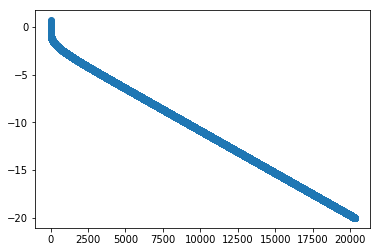

In [39]:
xs = np.array([np.array([i,j]) for i,j in zip(xcoords,ycoords)])
x_opt = np.array([1.0, 1.0])
err_1 = norm(xs - x_opt, axis=1)

# the local convergence can be observed in the last a few hundreds iterations
# We only visualize the last 100 steps
xi    = np.arange(0,len(err_1))

# the errors are plot in log scale, and the Q-linear convergence should form a
# straight line, we fit this line with linear regression. 

#slope, intercept, r_value, p_value, std_err = stats.linregress(xi, np.log(err_1[xi]))
#line = slope*xi+intercept
plt.plot(xi, np.log(err_1[xi]), '-o')

# the convergence rate will be simply the exp(slope) 
#print('convergence rate for exact line search is roughly {rate}'.format(rate=np.exp(slope)))

In [46]:
x0 = np.array([1.2, -1])
x, iter, xcoords, ycoords  = trust_region(dogleg, x0, 2)
print(x, iter)

[ 1.2 -1. ]
[1.13555365 1.17414822]
[1.12992125 1.2766903 ]
[1.12992125 1.2766903 ]
[1.12992125 1.2766903 ]
[1.12992125 1.2766903 ]
[1.02861784 1.04791483]
[1.01916667 1.03861139]
[1.0003364  1.00031834]
[1.00002228 1.00004445]
[1. 1.]
[1. 1.] 11


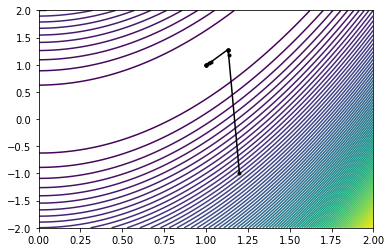

In [47]:
# In[6]:


plt.contour(X, Y, Z, 90);
plt.plot(xcoords, ycoords, '-k', marker='.')

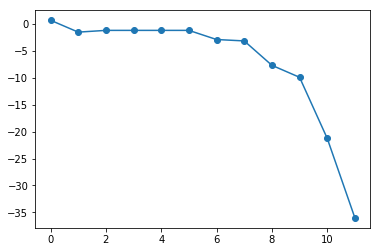

In [53]:
xs = np.array([np.array([i,j]) for i,j in zip(xcoords,ycoords)])

x_opt = np.array([1.0, 1.0])
err_1 = norm(xs - x_opt, axis=1)
xi    = np.arange(0,len(err_1))

plt.plot(xi, np.log(err_1+np.finfo(float).eps), '-o')